In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
def calc_entropy(p_arr):
    if abs(sum(p_arr) - 1) > 1e-10:
        print(sum(p_arr))
        return
    e = 0
    for i in p_arr:
        if i < 1e-10:
            continue
        e -= i * np.log2(i)
    return e

In [3]:
prob_arr = [1/6, 1/9, 1/6, 1/9, 1/36, 1/12, 1/6, 1/12, 1/12]
print(prob_arr)

# calc_entropy([0.17, 0.08, 0.13, 0.62])
# calc_entropy([0.08, 0.12, 0.8])
# calc_entropy([0.17, 0.1, 0.1, 0.63])
# calc_entropy([0.16, 0.03, 0.81])
# calc_entropy([0.02, 0.19, 0.1, 0.69])
# calc_entropy([0.06, 0.3, 0.64])
# calc_entropy([0.23, 0.08, 0.01, 0.68])
# calc_entropy([0.02, 0.1, 0.88])
calc_entropy(prob_arr)

[0.16666666666666666, 0.1111111111111111, 0.16666666666666666, 0.1111111111111111, 0.027777777777777776, 0.08333333333333333, 0.16666666666666666, 0.08333333333333333, 0.08333333333333333]


3.0367586814570005

### ハフマン符号を計算してみる

In [7]:
def get_min_syms(d_inv, n):
    """
    下からn番目までの記号を取り出す?
    """
    min_prob = min(d_inv)
    min_prob_syms = d_inv.pop(min_prob)
    
    rem_len = n - len(min_prob_syms)
    # オーバー
    if rem_len < 0:
        # ここが逆だった?
        min_prob_syms.sort(reverse=False)
        return min_prob_syms[:n]
    elif rem_len == 0:
        return min_prob_syms
    else:
        # 足りない場合は再帰
        return min_prob_syms + get_min_syms(d_inv, rem_len)

def create_connection_dict(prob_d):
    prob_d_cp = prob_d.copy()
    cnct_d = {}
    next_key = max(prob_d_cp) + 1

    while len(prob_d_cp) > 1:
        prob_d_inv = {}
        # 逆引き辞書作成
        for k, v in prob_d_cp.items():
            if v in prob_d_inv:
                prob_d_inv[v].append(k)
            else:
                prob_d_inv[v] = [k]

        print(prob_d_inv)

        min_syms = get_min_syms(prob_d_inv, 2)

        prob_d_cp[next_key] = sum(v for k, v in prob_d_cp.items() if k in min_syms)
        cnct_d[next_key] = sorted(min_syms)
        
        for i in min_syms:
            prob_d_cp.pop(i)
    
        print(prob_d_cp)
        print(cnct_d)
        next_key += 1

    return cnct_d

def generate_code(cnct_d, code_d):
    """
    枝の繋がりから符号を作成
    """
    max_key = max(cnct_d)
    children = cnct_d.pop(max_key)
    
    print(cnct_d)
    
    for i, j in enumerate(children):
        if max_key in code_d:
            code_d[j] = code_d[max_key] + str(i)
        else:
            code_d[j] = str(i)
    
    if max_key in code_d:
        code_d.pop(max_key)
    print(code_d)
    
    if any(cnct_d):
        generate_code(cnct_d, code_d)

In [8]:
# prob_arr = np.array([0.2, 0.19, 0.07, 0.05, 0.49])
# prob_arr = np.array([0.05, 0.05, 0.05, 0.05, 0.8])
# prob_arr = np.array([0.12, 0.01, 0.22, 0.07, 0.02, 0.56])
prob_arr = np.array([0.25, 0.07, 0.07, 0.04, 0.57])
print(prob_arr.sum())
prob_dict = {k: v for k, v in enumerate(prob_arr)}

connect_dict = create_connection_dict(prob_dict)

print("#" * 100)

code_dict = {}
generate_code(connect_dict, code_dict)

sorted_keys = sorted(code_dict.keys())
print("answer: ", end="")
for i in sorted_keys:
    print(code_dict[i], end=" ")
print()

1.0
{0.25: [0], 0.07: [1, 2], 0.04: [3], 0.57: [4]}
{0: 0.25, 2: 0.07, 4: 0.57, 5: 0.11000000000000001}
{5: [1, 3]}
{0.25: [0], 0.07: [2], 0.57: [4], 0.11000000000000001: [5]}
{0: 0.25, 4: 0.57, 6: 0.18000000000000002}
{5: [1, 3], 6: [2, 5]}
{0.25: [0], 0.57: [4], 0.18000000000000002: [6]}
{4: 0.57, 7: 0.43000000000000005}
{5: [1, 3], 6: [2, 5], 7: [0, 6]}
{0.57: [4], 0.43000000000000005: [7]}
{8: 1.0}
{5: [1, 3], 6: [2, 5], 7: [0, 6], 8: [4, 7]}
####################################################################################################
{5: [1, 3], 6: [2, 5], 7: [0, 6]}
{4: '0', 7: '1'}
{5: [1, 3], 6: [2, 5]}
{4: '0', 0: '10', 6: '11'}
{5: [1, 3]}
{4: '0', 0: '10', 2: '110', 5: '111'}
{}
{4: '0', 0: '10', 2: '110', 1: '1110', 3: '1111'}
answer: 10 1110 110 1111 0 


### ランレングス・ハフマン符号

In [6]:
def run_length_each_prob(Pb, N):
    """
    各長さの確率
    """
    return np.array([(1 - Pb) ** i * Pb for i in range(N)] + [(1 - Pb) ** N])

def calc_source_len_mean(Pb, N):
    return (1 - (1 - Pb) ** N) / Pb

In [7]:
Pb = 0.007
N = 4

prob_arr = run_length_each_prob(Pb, N)
print(prob_arr, prob_arr.sum())

prob_dict = {k: v for k, v in enumerate(prob_arr)}

connect_dict = create_connection_dict(prob_dict)

print("#" * 100)

code_dict = {}
generate_code(connect_dict, code_dict)

len_arr = np.array([len(code_dict[k]) for k in sorted(code_dict.keys())])

codeword_len_mean = np.dot(prob_arr, len_arr)
print("L = %f" % codeword_len_mean)
source_len_mean = calc_source_len_mean(Pb, N)
print("n_N = %f" % source_len_mean)

print("l_N = %f" % (codeword_len_mean / source_len_mean))

[0.007      0.006951   0.00690234 0.00685403 0.97229263] 1.0
{0.007: [0], 0.006951: [1], 0.006902343: [2], 0.006854026599000001: [3], 0.972292630401: [4]}
{0: 0.007, 1: 0.006951, 4: 0.972292630401, 5: 0.013756369599}
{5: [2, 3]}
{0.007: [0], 0.006951: [1], 0.972292630401: [4], 0.013756369599: [5]}
{4: 0.972292630401, 5: 0.013756369599, 6: 0.013951}
{5: [2, 3], 6: [0, 1]}
{0.972292630401: [4], 0.013756369599: [5], 0.013951: [6]}
{4: 0.972292630401, 7: 0.027707369598999998}
{5: [2, 3], 6: [0, 1], 7: [5, 6]}
{0.972292630401: [4], 0.027707369598999998: [7]}
{8: 1.0}
{5: [2, 3], 6: [0, 1], 7: [5, 6], 8: [4, 7]}
####################################################################################################
{5: [2, 3], 6: [0, 1], 7: [5, 6]}
{4: '0', 7: '1'}
{5: [2, 3], 6: [0, 1]}
{4: '0', 5: '10', 6: '11'}
{5: [2, 3]}
{4: '0', 5: '10', 0: '110', 1: '111'}
{}
{4: '0', 0: '110', 1: '111', 2: '100', 3: '101'}
L = 1.055415
n_N = 3.958196
l_N = 0.266640


### ZL符号

In [8]:
# symbol_series = "AAAAAAAAAAAABBAAAABA"
# symbol_series = "ABAAABAAABABBBABABAB"
# symbol_series = "ABAAABBAAAABBABABAAA"
symbol_series = "AAAAAAAABBBABABBAABB"

codes = []
known_patterns = {}

i = 0
while i < len(symbol_series):
    for j in range(i):
        for l in range(1, i - j + 1):
            pattern = symbol_series[j:j+l]
            if pattern not in known_patterns:
                known_patterns[pattern] = (j, l)
#                 print(i, j, l, pattern)
    for j in range(i, 0, -1):
        pattern = symbol_series[i:i + j]
        print(i, j, pattern)
        if pattern in known_patterns:
            if i + j >= len(symbol_series):
                print("末尾余り")
                i = float("inf")
            else:
                codes.append(known_patterns[pattern] + (symbol_series[i+j],))
                i += j + 1
            break
    else:
        codes.append((0, 0, symbol_series[i]))
        i += 1
    print("#" * 100)
    
# print(known_patterns)
print(codes)

for i in codes:
    print(i[1] + 1, end=" ")
print()

####################################################################################################
1 1 A
####################################################################################################
3 3 AAA
####################################################################################################
7 7 ABBBABA
7 6 ABBBAB
7 5 ABBBA
7 4 ABBB
7 3 ABB
7 2 AB
7 1 A
####################################################################################################
9 9 BBABABBAA
9 8 BBABABBA
9 7 BBABABB
9 6 BBABAB
9 5 BBABA
9 4 BBAB
9 3 BBA
9 2 BB
9 1 B
####################################################################################################
11 11 ABABBAABB
11 10 ABABBAABB
11 9 ABABBAABB
11 8 ABABBAAB
11 7 ABABBAA
11 6 ABABBA
11 5 ABABB
11 4 ABAB
11 3 ABA
11 2 AB
####################################################################################################
14 14 BBAABB
14 13 BBAABB
14 12 BBAABB
14 11 BBAABB
14 10 BBAABB
14 9 BBAABB
14 8 BBAABB
14 7 BBAABB
14

### 実用的なZL

In [16]:
offset_bit = 3
length_bit = 2

# symbol_series = "AAABAABAAABB"
symbol_series = "ABAAAABAABAA"

offset = 1 << offset_bit
length = 1 << length_bit

buffer = "A" * offset + symbol_series[:length]

symbol_remain = symbol_series[length:]

codes = []
while len(buffer) > offset:
    print(buffer[:offset] + "|" + buffer[offset:])
    print(symbol_remain)
    
    known_patterns = {}
    for i in range(offset):
        for j in range(i + 1, offset + 1):
            pattern = buffer[i:j]
            if pattern not in known_patterns:
                known_patterns[pattern] = (i, j - i)
#     print(known_patterns)
    for l in range(length - 1, 0, -1):
        pattern = buffer[offset:offset+l]
        print(i, j, pattern)
        if len(buffer) <= offset+l:
            buffer = ""
            break
        if pattern in known_patterns:
            codes.append(known_patterns[pattern] + (buffer[offset+l],))
            buffer = buffer[l+1:] + symbol_remain[:l+1]
            symbol_remain = symbol_remain[l+1:]
            break
    else:
        codes.append((0, 0, buffer[offset]))
        buffer = buffer[1:] + symbol_remain[:1]
        symbol_remain = symbol_remain[1:]
    print("#" * 100)
print(codes)

for i in codes:
    print(format(i[0], "0%db" % offset_bit) + format(i[1], "0%db" % length_bit) + str((i[2] == "B") * 1), end=" ")
print()

AAAAAAAA|ABAA
AABAABAA
7 8 ABA
7 8 AB
7 8 A
####################################################################################################
AAAAAAAB|AAAA
BAABAA
7 8 AAA
####################################################################################################
AAABAAAA|BAAB
AA
7 8 BAA
####################################################################################################
AAAABAAB|AA

7 8 AA
####################################################################################################
[(0, 1, 'B'), (0, 3, 'A'), (3, 3, 'B')]
000011 000110 011111 


### 実用的なZL (復号)

In [10]:
offset_bit = 4
length_bit = 3

codes = "00000011 11001000 10010111 00000110"
codes = codes.split(" ")
codes = [(int(i[:offset_bit], 2), int(i[offset_bit:offset_bit+length_bit], 2), chr(ord("A") + int(i[-1]))) for i in codes]
codes

offset = 1 << offset_bit
length = 1 << length_bit

buffer = "A" * offset
symbol_series = ""

for i in codes:
    print(i)
    print(buffer[:offset] + "|" + buffer[offset:])
    pattern = buffer[i[0]:i[0]+i[1]] + i[2]
    symbol_series += pattern
    buffer = (buffer + pattern)[i[1]+1:]

print(buffer[:offset] + "|" + buffer[offset:] + "\n")
print(symbol_series)

(0, 1, 'B')
AAAAAAAAAAAAAAAA|
(12, 4, 'A')
AAAAAAAAAAAAAAAB|
(9, 3, 'B')
AAAAAAAAAABAAABA|
(0, 3, 'A')
AAAAAABAAABAABAB|
AABAAABAABABAAAA|

ABAAABAABABAAAA


In [11]:
chr(ord("A") + 1)

'B'

### ボール3種. 2個取り出す. 戻さない.
とりあえず結合エントロピーを計算

In [12]:
# ball_count = [1, 2, 2]
ball_count = [2, 1, 1]
# ball_count = [1, 3, 3]
# ball_count = [1, 4, 3]

joint_prob_arr = []

for i, j in enumerate(ball_count):
    pj = j / sum(ball_count)
    ball_count_cp = ball_count.copy()
    ball_count_cp[i] -= 1
    for k in ball_count_cp:
        pk = k / sum(ball_count_cp)
        joint_prob_arr.append(pj * pk)

print(joint_prob_arr)
calc_entropy(joint_prob_arr)

[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.0, 0.08333333333333333, 0.16666666666666666, 0.08333333333333333, 0.0]


2.751629167387823

条件付きエントロピー H(Y|X)

In [13]:
# ball_count = [2, 3, 2]
# ball_count = [3, 4, 4]
# ball_count = [1, 4, 3]
ball_count = [4, 2, 2]

e = 0

for i, j in enumerate(ball_count):
    pj = j / sum(ball_count)
    ball_count_cp = ball_count.copy()
    ball_count_cp[i] -= 1
    for k in ball_count_cp:
        if k < 1e-10:
            continue
        pk = k / sum(ball_count_cp)
        e -= pj * pk * np.log2(pk)

e

1.4677201004744993

### 2元対称通信路

In [14]:
# px0 = 0.9
# pe = 0.38
# pe, px0 = 0.91, 0.06
# pe, px0 = 0.34, 0.39
pe, px0 = 0.78, 0.03

pxl = [px0, 1 - px0]

Hx = calc_entropy(pxl)

py0 = px0 * (1 - pe) + (1 - px0) * pe
pyl = [py0, 1 - py0]

Hx_bar_y = 0

for i in range(2):
    pyi = pyl[i]
    for j in range(2):
        pxj = pxl[j]
        if i != j:
            pxj_bar_yi = pxj * pe / pyi
        else:
            pxj_bar_yi = pxj * (1 - pe) / pyi
        Hx_bar_y -= pyi * pxj_bar_yi * np.log2(pxj_bar_yi)

print(Hx)
print(Hx_bar_y)
print(Hx - Hx_bar_y)

0.1943918578315762
0.16488119024843398
0.02951066758314222


In [15]:
def calc_matual_info(pe, px0):
    pxl = [px0, 1 - px0]
    py0 = px0 * (1 - pe) + (1 - px0) * pe
    pyl = [py0, 1 - py0]
    
    Hy = calc_entropy(pyl)
    
    Ixy = Hy
    for i in range(2):
        for j in range(2):
            if i == j:
                Ixy += pxl[i] * (1 - pe) * np.log2(1 - pe)
            else:
                Ixy += pxl[i] * pe * np.log2(pe)
    return Ixy

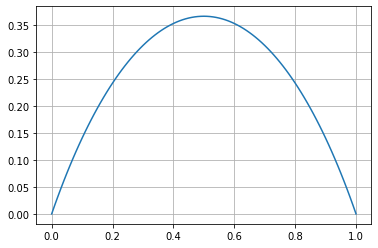

In [16]:
pe = 0.84

x = np.linspace(0, 1, 101)
y = np.array([calc_matual_info(0.84, i) for i in x])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.grid()
plt.show()

### 生成行列

In [17]:
# G_str = """|1　0　0　0　1　0　0|
# G = |0　1　1　0　0　1　0|
# 　　|0　1　0　1　1　0　1|"""
G_str = """|1　0　0　0　1　0　0|
G = |0　1　1　0　0　1　0|
　　|0　1　0　1　1　0　1|"""

# info_series = "001 111 100"
info_series = "011 001 110"

G_str = G_str.split("\n")
G_str = [i.split("　") for i in G_str]

info_series = np.matrix([[int(j) for j in i] for i in info_series.split(" ")])

G = []
for i in range(len(G_str)):
    tmp = []
    for j in G_str[i]:
        m = re.match(r'.*([01]+)', j)
        if m:
            tmp.append(int(m.groups()[0]))
    G.append(tmp)
G = np.matrix(G)

print(info_series)
print(G)

c = np.matmul(info_series, G) % 2
print(c)
for i in c.tolist():
    for j in i:
        print(j, end="")
    print(end=" ")
print()

[[0 1 1]
 [0 0 1]
 [1 1 0]]
[[1 0 0 0 1 0 0]
 [0 1 1 0 0 1 0]
 [0 1 0 1 1 0 1]]
[[0 0 1 1 1 1 1]
 [0 1 0 1 1 0 1]
 [1 1 1 0 1 1 0]]
0011111 0101101 1110110 


### (7, 4)ハミング符号の復号

In [18]:
# info_series = "0 0 1 1 0 1 0"
info_series = "0 0 0 0 1 1 0"

info_series = np.matrix([int(i) for i in info_series.split(" ")])

Ht = np.matrix([
    [1, 1, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
 
s = np.matmul(info_series, Ht) % 2

e = []

for i, j in enumerate(Ht):
    if np.array_equal(j, s):
        print(i)
        e.append(1)
    else:
        e.append(0)
e = np.matrix(e)

print(info_series)
print(Ht)
print(s)

y = info_series + e

print(y)

for i in range(4):
    print(y[0, i], end="")
print()

3
[[0 0 0 0 1 1 0]]
[[1 1 1]
 [0 1 1]
 [1 0 1]
 [1 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
[[1 1 0]]
[[0 0 0 1 1 1 0]]
0001
